# Exploring the Dynamics of Film Industry for Informed Decision-Making

In [135]:
import json
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Data Cleaning

### Movies

In [136]:
movies = pd.read_csv('tmdb_5000_movies.csv')
movies.head(2)

# 4803 rows × 20 columns

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [137]:
movies.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [138]:
movies.shape

(4803, 20)

In [139]:
movies = movies.drop(['homepage', 'keywords', 'id', 'overview', 'spoken_languages', 'status', 'tagline','original_title'], axis=1, errors='ignore')
movies.head(2)

#4803 rows × 12 columns

,budget,genres,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",en,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",en,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500


In [140]:
def extract_data(json_str, key):
    """
    Extracts data from a JSON string based on the provided key.
    
    Args:
    - json_str (str): The JSON formatted string.
    - key (str): The key to extract data from.

    Returns:
    - str: A comma-separated string of extracted values.
    """
    try:
        data_list = json.loads(json_str)
    except json.JSONDecodeError:
        return json_str  # or return an empty string: return ''
    
    extracted_values = [item[key] for item in data_list]
    return ", ".join(extracted_values)

# Applying the function to various columns
movies['genres'] = movies['genres'].apply(lambda x: extract_data(x, 'name'))
movies['production_companies'] = movies['production_companies'].apply(lambda x: extract_data(x, 'name'))
movies['production_countries'] = movies['production_countries'].apply(lambda x: extract_data(x, 'name'))

movies.head(2)

#4803 rows × 12 columns

,budget,genres,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,title,vote_average,vote_count
0,237000000,"Action, Adventure, Fantasy, Science Fiction",en,150.437577,"Ingenious Film Partners, Twentieth Century Fox...","United States of America, United Kingdom",2009-12-10,2787965087,162.0,Avatar,7.2,11800
1,300000000,"Adventure, Fantasy, Action",en,139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",United States of America,2007-05-19,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500


In [141]:
# Check if title is garbled, and Drop the garbled rows

def is_garbled(title):
    
    ''' The following regex checks for titles containing characters outside the 
        typical alphanumeric, space, and common punctuation range.'''
    
    return not bool(re.match(r'^[a-zA-Z0-9\s\.,;:\'\"!?()-]*$', title))


garbled_indices = movies[movies['title'].apply(is_garbled)].index
movies.drop(garbled_indices, inplace=True)

movies.head(2)

# 4705 rows × 12 columns

,budget,genres,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,title,vote_average,vote_count
0,237000000,"Action, Adventure, Fantasy, Science Fiction",en,150.437577,"Ingenious Film Partners, Twentieth Century Fox...","United States of America, United Kingdom",2009-12-10,2787965087,162.0,Avatar,7.2,11800
1,300000000,"Adventure, Fantasy, Action",en,139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",United States of America,2007-05-19,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500


In [142]:
# Check if production_companies has garbled characters, and Drop them.

def filter_garbled_names(names_str):
    
    names = [name.strip() for name in names_str.split(',')]
    
    # use a regular expression to check for non-ASCII characters
    legitimate_names = [name for name in names if not re.search(r'[^\x00-\x7F]', name)]
    
    return ', '.join(legitimate_names)


movies['production_companies'] = movies['production_companies'].apply(filter_garbled_names)


In [143]:
movies.head()

# 4705 rows × 12 columns

,budget,genres,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,title,vote_average,vote_count
0,237000000,"Action, Adventure, Fantasy, Science Fiction",en,150.437577,"Ingenious Film Partners, Twentieth Century Fox...","United States of America, United Kingdom",2009-12-10,2787965087,162.0,Avatar,7.2,11800
1,300000000,"Adventure, Fantasy, Action",en,139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",United States of America,2007-05-19,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"Action, Adventure, Crime",en,107.376788,"Columbia Pictures, Danjaq, B24","United Kingdom, United States of America",2015-10-26,880674609,148.0,Spectre,6.3,4466
3,250000000,"Action, Crime, Drama, Thriller",en,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",United States of America,2012-07-16,1084939099,165.0,The Dark Knight Rises,7.6,9106
4,260000000,"Action, Adventure, Science Fiction",en,43.926995,Walt Disney Pictures,United States of America,2012-03-07,284139100,132.0,John Carter,6.1,2124


### Credits

In [144]:
credits = pd.read_csv('tmdb_5000_credits.csv')
credits.head(2)

# 4803 rows × 4 columns

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [145]:
credits = credits.drop(['crew', 'movie_id'], axis=1)

In [146]:
# get first 10 actors from each movie

def extract_actors(cast_str):
    # Check if the string is a valid JSON
    try:
        cast_list = json.loads(cast_str)
    except json.JSONDecodeError:
        return cast_str  # or return an empty string: return ''
    
    names = [actor['name'] for actor in cast_list][:10] #first 10
    return ", ".join(names)

# Apply the function and correct garbled characters
credits['cast'] = credits['cast'].apply(extract_actors)
credits['cast'] = credits['cast'].str.replace(r"\u00e5", "g")

credits.head()

# 4803 rows × 2 columns

/var/folders/j2/d6gfnc_j1w92nhthf02vfpy00000gn/T/ipykernel_83540/780571461.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  credits['cast'] = credits['cast'].str.replace(r"\u00e5", "g")


,title,cast
0,Avatar,"Sam Worthington, Zoe Saldana, Sigourney Weaver..."
1,Pirates of the Caribbean: At World's End,"Johnny Depp, Orlando Bloom, Keira Knightley, S..."
2,Spectre,"Daniel Craig, Christoph Waltz, Léa Seydoux, Ra..."
3,The Dark Knight Rises,"Christian Bale, Michael Caine, Gary Oldman, An..."
4,John Carter,"Taylor Kitsch, Lynn Collins, Samantha Morton, ..."


In [147]:
# Check if title is garbled, and then Drop the garbled rows

def is_garbled(title):
    
    ''' The following regex checks for titles containing characters outside the 
        typical alphanumeric, space, and common punctuation range.'''
    
    return not bool(re.match(r'^[a-zA-Z0-9\s\.,;:\'\"!?()-]*$', title))


garbled_indices = credits[credits['title'].apply(is_garbled)].index
credits.drop(garbled_indices, inplace=True)

#credits.head()

# 4705 rows × 12 columns

In [148]:
# Check if cast has garbled characters, and then Drop them.

def filter_garbled_cast(names_str):
    
    names = [name.strip() for name in names_str.split(',')]
    
    # use a regular expression to check for non-ASCII characters
    legitimate_names = [name for name in names if not re.search(r'[^\x00-\x7F]', name)]
    
    return ', '.join(legitimate_names)


credits['cast'] = credits['cast'].apply(filter_garbled_cast)


In [149]:
credits.head()

# 4705 rows × 2 columns

,title,cast
0,Avatar,"Sam Worthington, Zoe Saldana, Sigourney Weaver..."
1,Pirates of the Caribbean: At World's End,"Johnny Depp, Orlando Bloom, Keira Knightley, S..."
2,Spectre,"Daniel Craig, Christoph Waltz, Ralph Fiennes, ..."
3,The Dark Knight Rises,"Christian Bale, Michael Caine, Gary Oldman, An..."
4,John Carter,"Taylor Kitsch, Lynn Collins, Samantha Morton, ..."


### Combine Datasets

In [150]:
df = pd.concat([movies, credits.drop(columns='title')], axis=1)
df.head(2)

# 4705 rows × 13 columns

,budget,genres,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,title,vote_average,vote_count,cast
0,237000000,"Action, Adventure, Fantasy, Science Fiction",en,150.437577,"Ingenious Film Partners, Twentieth Century Fox...","United States of America, United Kingdom",2009-12-10,2787965087,162.0,Avatar,7.2,11800,"Sam Worthington, Zoe Saldana, Sigourney Weaver..."
1,300000000,"Adventure, Fantasy, Action",en,139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",United States of America,2007-05-19,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500,"Johnny Depp, Orlando Bloom, Keira Knightley, S..."


In [151]:
# Replace empty strings or white spaces with NaN
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

# Drop rows containing NaN values
df.dropna(inplace=True)

df.head(2)

# 4335 rows × 13 columns

,budget,genres,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,title,vote_average,vote_count,cast
0,237000000,"Action, Adventure, Fantasy, Science Fiction",en,150.437577,"Ingenious Film Partners, Twentieth Century Fox...","United States of America, United Kingdom",2009-12-10,2787965087,162.0,Avatar,7.2,11800,"Sam Worthington, Zoe Saldana, Sigourney Weaver..."
1,300000000,"Adventure, Fantasy, Action",en,139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",United States of America,2007-05-19,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500,"Johnny Depp, Orlando Bloom, Keira Knightley, S..."


In [152]:
# Drop rows where 'budget' or 'revenue' is 0
df = df[(df['budget'] != 0) & (df['revenue'] != 0)]
df.head(2)

# 3166 rows × 13 columns

,budget,genres,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,title,vote_average,vote_count,cast
0,237000000,"Action, Adventure, Fantasy, Science Fiction",en,150.437577,"Ingenious Film Partners, Twentieth Century Fox...","United States of America, United Kingdom",2009-12-10,2787965087,162.0,Avatar,7.2,11800,"Sam Worthington, Zoe Saldana, Sigourney Weaver..."
1,300000000,"Adventure, Fantasy, Action",en,139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",United States of America,2007-05-19,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500,"Johnny Depp, Orlando Bloom, Keira Knightley, S..."


In [153]:
# Save as a csv file
df.to_csv('Movies_new_FTD.csv', index=False)

In [154]:
df.shape

(3122, 13)

## EDA

In [123]:
df.describe()

,budget,popularity,revenue,runtime,vote_average,vote_count
count,4.705000e+03,4705.000000,4.705000e+03,4703.000000,4705.000000,4705.000000
mean,2.909153e+07,21.538013,8.264696e+07,106.990219,6.092455,692.128162
std,4.080357e+07,32.039288,1.638229e+08,22.657678,1.190633,1240.469289
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,8.000000e+05,4.680206,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,12.902975,1.925587e+07,104.000000,6.200000,235.000000
75%,4.000000e+07,28.227984,9.299184e+07,118.000000,6.800000,737.000000
max,3.800000e+08,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [124]:
df.head()

,budget,genres,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,title,vote_average,vote_count,cast
0,237000000,"Action, Adventure, Fantasy, Science Fiction",en,150.437577,"Ingenious Film Partners, Twentieth Century Fox...","United States of America, United Kingdom",2009-12-10,2787965087,162.0,Avatar,7.2,11800,"Sam Worthington, Zoe Saldana, Sigourney Weaver..."
1,300000000,"Adventure, Fantasy, Action",en,139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",United States of America,2007-05-19,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500,"Johnny Depp, Orlando Bloom, Keira Knightley, S..."
2,245000000,"Action, Adventure, Crime",en,107.376788,"Columbia Pictures, Danjaq, B24","United Kingdom, United States of America",2015-10-26,880674609,148.0,Spectre,6.3,4466,"Daniel Craig, Christoph Waltz, Ralph Fiennes, ..."
3,250000000,"Action, Crime, Drama, Thriller",en,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",United States of America,2012-07-16,1084939099,165.0,The Dark Knight Rises,7.6,9106,"Christian Bale, Michael Caine, Gary Oldman, An..."
4,260000000,"Action, Adventure, Science Fiction",en,43.926995,Walt Disney Pictures,United States of America,2012-03-07,284139100,132.0,John Carter,6.1,2124,"Taylor Kitsch, Lynn Collins, Samantha Morton, ..."


In [125]:
df.shape

(4705, 13)

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4705 entries, 0 to 4802
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4705 non-null   int64  
 1   genres                4705 non-null   object 
 2   original_language     4705 non-null   object 
 3   popularity            4705 non-null   float64
 4   production_companies  4705 non-null   object 
 5   production_countries  4705 non-null   object 
 6   release_date          4704 non-null   object 
 7   revenue               4705 non-null   int64  
 8   runtime               4703 non-null   float64
 9   title                 4705 non-null   object 
 10  vote_average          4705 non-null   float64
 11  vote_count            4705 non-null   int64  
 12  cast                  4705 non-null   object 
dtypes: float64(3), int64(3), object(7)
memory usage: 514.6+ KB


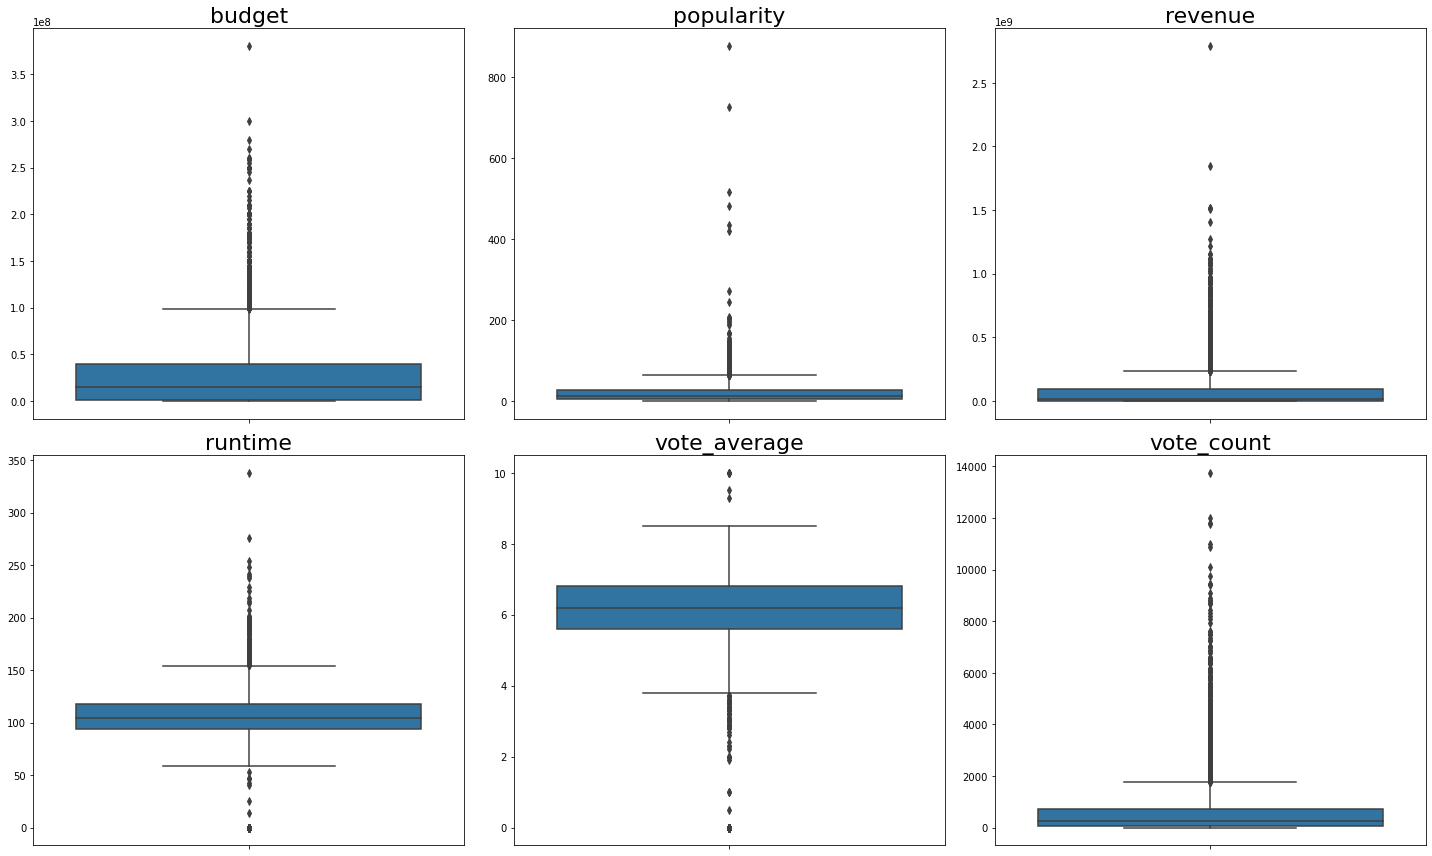

In [98]:
# List of numerical columns
numerical_columns = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']

# Plot boxplots for numerical columns
plt.figure(figsize=(20, 12))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(col, fontsize=22)
    plt.ylabel('')

plt.tight_layout()
plt.show()

In [157]:
from sklearn.ensemble import IsolationForest

# Selecting the numerical columns
numerical_cols = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']

# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Fit the model and predict the outliers
iso_forest_preds = iso_forest.fit_predict(df[numerical_cols])

# Extract the outliers
iso_forest_outliers = df[numerical_cols][iso_forest_preds == -1]

# Get the number of outliers detected by Isolation Forest
num_outliers_iso_forest = iso_forest_outliers.shape[0]

iso_forest_outliers, num_outliers_iso_forest


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


(         budget  popularity     revenue  runtime  vote_average  vote_count
 0     237000000  150.437577  2787965087    162.0           7.2       11800
 1     300000000  139.082615   961000000    169.0           6.9        4500
 2     245000000  107.376788   880674609    148.0           6.3        4466
 3     250000000  112.312950  1084939099    165.0           7.6        9106
 5     258000000  115.699814   890871626    139.0           5.9        3576
 ...         ...         ...         ...      ...           ...         ...
 3813    4000000   48.982550   400176459    238.0           7.7         970
 3865    3300000  192.528841    13092000    105.0           8.3        4254
 4065    2100000    0.039007        3330    126.0           0.0           0
 4302    1200000   88.377076     6000000    161.0           8.1        2311
 4535    2000000   39.756748      271841    207.0           8.2         878
 
 [157 rows x 6 columns],
 157)

In [158]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

# Scaling the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[numerical_cols])

# Initialize the One-Class SVM model
one_class_svm = OneClassSVM(nu=0.05, kernel="rbf", gamma=0.01)

# Fit the model and predict the outliers
svm_preds = one_class_svm.fit_predict(scaled_data)

# Extract the outliers
svm_outliers = df[numerical_cols][svm_preds == -1]

# Get the number of outliers detected by One-Class SVM
num_outliers_svm = svm_outliers.shape[0]

svm_outliers, num_outliers_svm


(         budget  popularity     revenue  runtime  vote_average  vote_count
 0     237000000  150.437577  2787965087    162.0           7.2       11800
 1     300000000  139.082615   961000000    169.0           6.9        4500
 2     245000000  107.376788   880674609    148.0           6.3        4466
 3     250000000  112.312950  1084939099    165.0           7.6        9106
 4     260000000   43.926995   284139100    132.0           6.1        2124
 ...         ...         ...         ...      ...           ...         ...
 4641        250    0.293649         203     72.0           7.5          12
 4647     250000    6.978907       56825     99.0           4.1          75
 4669     210000    2.043661     5000000     80.0           6.7          41
 4673     200000    0.622752     2200000     66.0           5.1          27
 4695     180000    7.072118      900000     89.0           7.8         112
 
 [156 rows x 6 columns],
 156)

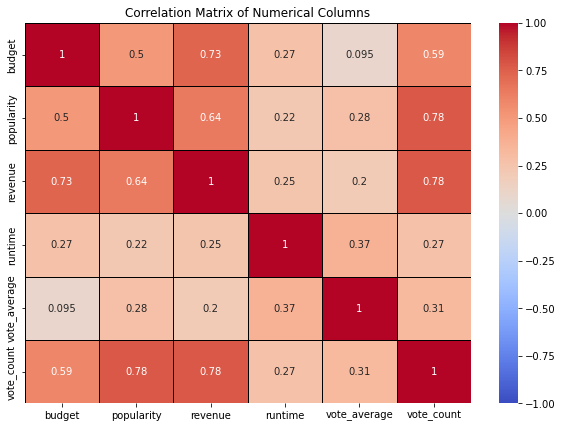

In [99]:
# Compute the correlation matrix
correlation_matrix = df[numerical_columns].corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, linecolor='black')
plt.title("Correlation Matrix of Numerical Columns")
plt.show()

strong positive correlation:

1. budget vs. revenue = means that movies with higher budgets tend to have higher box office revenue.

2. vote_count vs. revenue = movies with more votes/watches will get higher box office.

3. popularity vs. vote_count = popular movies also generally have more ratings.

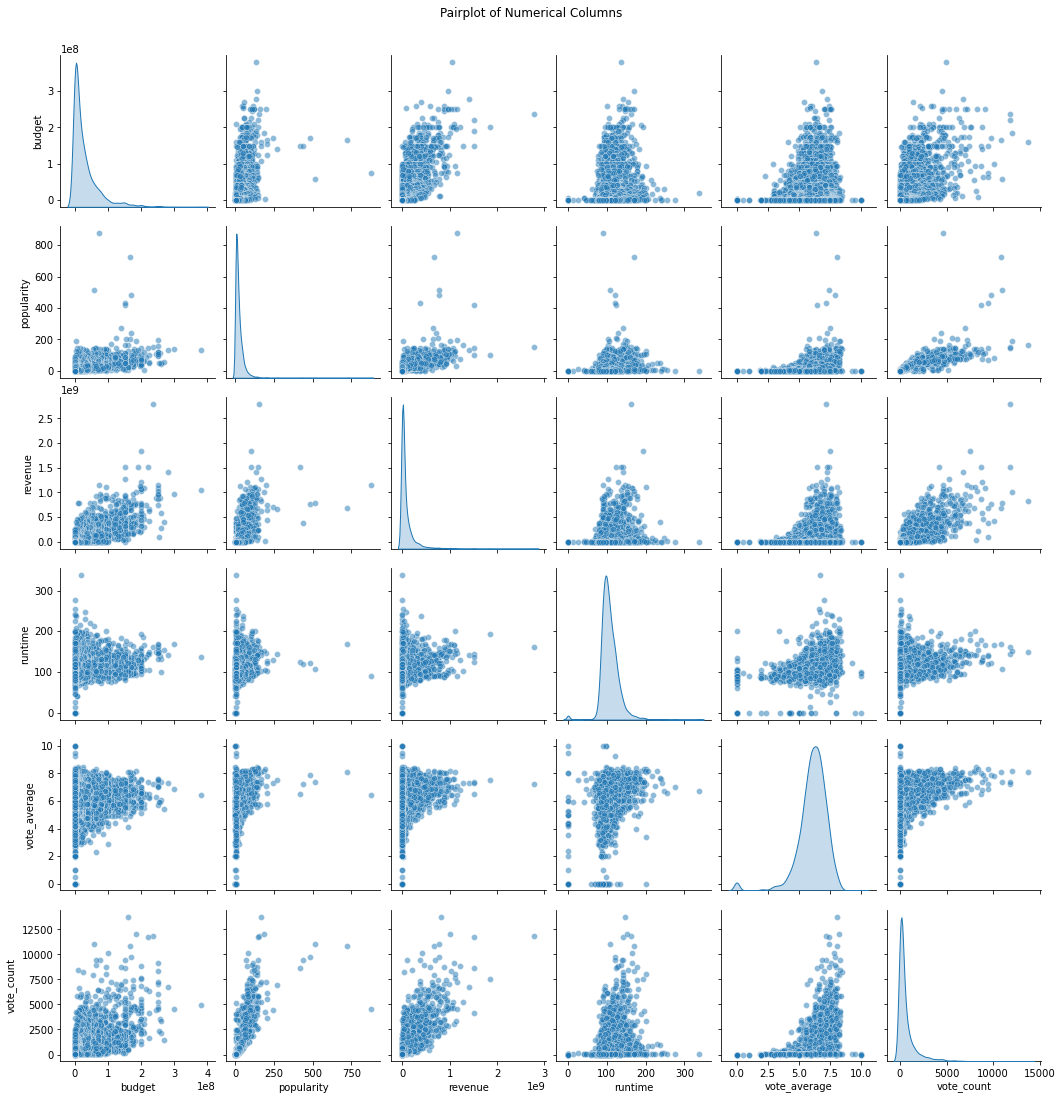

In [100]:
# Plot the pairplot for numerical columns to see relationships between them
sns.pairplot(df[numerical_columns], diag_kind="kde", plot_kws={'alpha':0.5})
plt.suptitle("Pairplot of Numerical Columns", y=1.02)
plt.show()

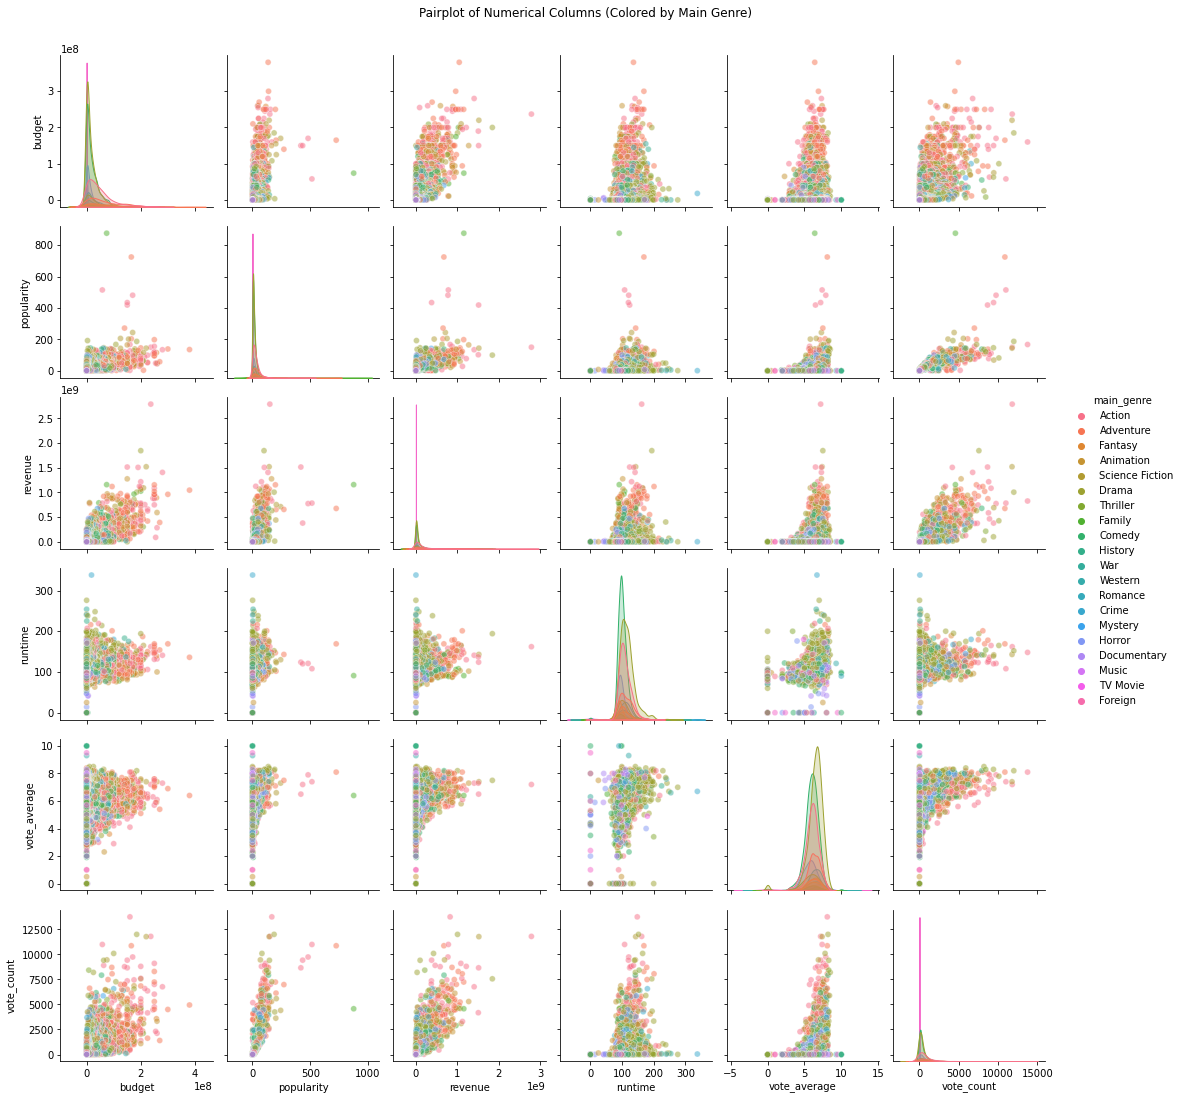

In [101]:
# Find the most common genre for each movie
df['main_genre'] = df['genres'].str.split(", ").apply(lambda x: x[0] if isinstance(x, list) and x else None)

# Plot the pairplot with colors representing the main genre
sns.pairplot(df[numerical_columns + ['main_genre']], hue='main_genre', diag_kind="kde", plot_kws={'alpha':0.5})
plt.suptitle("Pairplot of Numerical Columns (Colored by Main Genre)", y=1.02)
plt.show()

positive correlation

1. Budget vs. revenue
2. vote_count vs. revenue
3. popularity vs. vote_count